In [1]:
# Uncomment and run to reload libs
# import importlib
# import utils
# importlib.reload(utils)
# import utils.miscellaneous
# importlib.reload(utils.miscellaneous)


import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from scipy import stats

from utils import (
    logging,
    AVERAGE_PERIOD,
    RECOMMENDED_MUTATIONS_FILE,
    EXISTING_COMBO_FILE,
    FUTURE_COMBO_FILE,
    SCORE_DISTRIBUTION_PLOT,
    SCORE_TREND_PLOT,
)


In [2]:
pred_scores = pd.read_csv(RECOMMENDED_MUTATIONS_FILE)
existing_combo = pd.read_csv(EXISTING_COMBO_FILE)
dated_combo = pd.read_csv(FUTURE_COMBO_FILE)
dated_combo["Date"] = pd.to_datetime(dated_combo["Date"])


In [3]:
existing_combo["existing"] = True
pred_scores = pd.merge(existing_combo, pred_scores, on=("Accession", "Mut"), how="right")
pred_scores = pred_scores[pred_scores["existing"].isna()]


In [4]:
all_combo_scores = pd.merge(dated_combo, pred_scores, on=["Accession", "Mut"], how="right")
all_combo_scores["Hit"] = (~all_combo_scores["Date"].isna())


In [5]:
positive_res = all_combo_scores[all_combo_scores["Hit"]]
positive_res = positive_res.reset_index(drop=True)
positive_res = positive_res.groupby(["Accession", "Mut", "Date"]).mean().reset_index()

negative_res = all_combo_scores[~all_combo_scores["Hit"]]
negative_res = negative_res.reset_index(drop=True)
negative_res = negative_res.groupby(["Accession", "Mut"]).mean().reset_index()


In [6]:
negative_res["value"].mean() < positive_res["value"].mean()


True

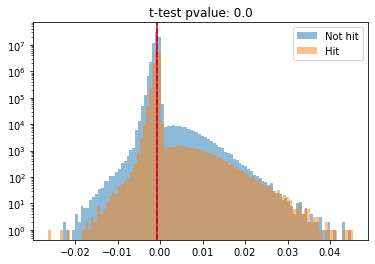

In [7]:
statistic, pvalue = stats.ttest_ind(
    negative_res["value"],
    positive_res["value"],
    alternative="less"
)

plt.hist(negative_res["value"], label="Not hit", bins=100, alpha=0.5)
plt.axvline(x=negative_res["value"].mean(), color="blue", linestyle="--")
plt.hist(positive_res["value"], label="Hit", bins=100, alpha=0.5)
plt.axvline(x=positive_res["value"].mean(), color="red")
plt.yscale("log")
plt.legend()
plt.title(f"t-test pvalue: {pvalue}")
plt.savefig(SCORE_DISTRIBUTION_PLOT, bbox_inches="tight")
logging.info(f"{SCORE_DISTRIBUTION_PLOT} saved!")
plt.show()
plt.close()


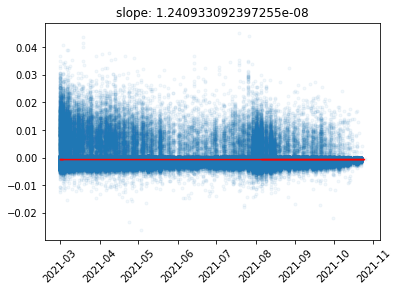

In [8]:
slope, intercept, r, p, se = stats.linregress(date2num(positive_res["Date"]), positive_res["value"])
plt.plot_date(positive_res["Date"], positive_res["value"], fmt=".", alpha=0.05)
plt.plot(
    positive_res["Date"],
    intercept + slope*date2num(positive_res["Date"]),
    'r',
    label='fitted line'
)
plt.xticks(rotation=45)
plt.title(f"slope: {slope}")
plt.show()
plt.close()


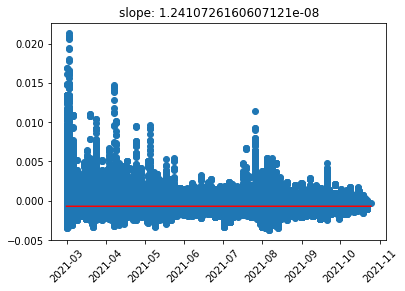

In [9]:
positive_res_ma = positive_res.sort_values("Date").reset_index()
positive_res_ma["value_ma"] = positive_res_ma["value"].rolling(AVERAGE_PERIOD).mean()
positive_res_ma = positive_res_ma.dropna()

slope, intercept, r, p, se = stats.linregress(date2num(positive_res_ma["Date"]), positive_res_ma["value"])

plt.plot_date(positive_res_ma["Date"], positive_res_ma["value_ma"])
plt.plot(
    positive_res_ma["Date"],
    intercept + slope*date2num(positive_res_ma["Date"]),
    'r',
    label='fitted line'
)
plt.xticks(rotation=45)
plt.title(f"slope: {slope}")
plt.savefig(SCORE_TREND_PLOT, bbox_inches="tight")
logging.info(f"{SCORE_TREND_PLOT} saved!")
plt.show()
plt.close()


In [10]:
# all_date = positive_res["Date"].unique()
# all_date.sort()

# auc_scores = []

# for c_date in all_date:
#     logging.info(f"{c_date}")
#     true_positive: pd.DataFrame = positive_res[positive_res["Date"] <= c_date]
#     all_muts = set([
#         *true_positive["Accession"].unique(),
#         *true_positive["Mut"].unique()
#     ])
#     true_negative = negative_res[
#         (negative_res["Accession"].isin(all_muts)) &
#         (negative_res["Mut"].isin(all_muts))
#     ]
#     if len(true_positive) and len(true_negative):
#         combined = pd.concat([true_positive, true_negative])
#         auc_scores.append({
#             "Date": c_date,
#             "AUC_score": metrics.roc_auc_score(combined["Hit"], combined["value"])
#         })
#         # print(all_muts)

# auc_scores = pd.DataFrame.from_records(auc_scores)
# auc_scores["Date"] = pd.to_datetime(auc_scores["Date"])

# plt.plot_date(auc_scores["Date"], auc_scores["AUC_score"])
